# Session #4 Homework


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_score, recall_score

from tqdm.auto import tqdm

%matplotlib inline

## Preparation 

In [2]:
df = pd.read_csv('CreditScoring.csv')
df.columns = df.columns.str.lower()

Some of the features are encoded as numbers. Use the following code to de-code them:

In [3]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

Prepare the numerical variables:

In [4]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Remove clients with unknown default status.

In [5]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable.

In [6]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

In [7]:
df.head()

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price,default
0,9,rent,60,30,married,no,freelance,73,129,0,0,800,846,0
1,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658,0
2,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985,1
3,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325,0
4,0,rent,36,26,single,no,fixed,46,107,0,0,310,910,0


## Your code

What are the categorical variables? What are the numerical?

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4454 entries, 0 to 4453
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   seniority  4454 non-null   int64 
 1   home       4454 non-null   object
 2   time       4454 non-null   int64 
 3   age        4454 non-null   int64 
 4   marital    4454 non-null   object
 5   records    4454 non-null   object
 6   job        4454 non-null   object
 7   expenses   4454 non-null   int64 
 8   income     4454 non-null   int64 
 9   assets     4454 non-null   int64 
 10  debt       4454 non-null   int64 
 11  amount     4454 non-null   int64 
 12  price      4454 non-null   int64 
 13  default    4454 non-null   int32 
dtypes: int32(1), int64(9), object(4)
memory usage: 469.9+ KB


Categorical variables are `home, marital, records, job and default`.  
Numerical variables are `seniority, time, age, expenses, income, assets, debt, amount and price`.

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`

In [9]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.default.values
y_val = df_val.default.values
y_test = df_test.default.values

del df_train['default']
del df_val['default']
del df_test['default']

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the "default" variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenses']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [10]:
num_variables = ['seniority', 'time', 'age', 'expenses', 'income', 'assets', 'debt', 'amount', 'price']

for variable in num_variables:
    model = LogisticRegression()
    model.fit(df_train[[variable]], y_train)
    
    y_pred = model.predict_proba(df_train[[variable]])[:,1]
    print(variable, roc_auc_score(y_train, y_pred).round(3))

seniority 0.709
time 0.561
age 0.573
expenses 0.499
income 0.682
assets 0.649
debt 0.495
amount 0.591
price 0.504


Which numerical variable (among the following 4) has the highest AUC?

- seniority
- time
- income
- debt

`seniority ` varible has the hightest AUC.

## Training the model

From now on, use these columns only:

```
['seniority', 'income', 'assets', 'records', 'job', 'home']
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [11]:
columns = ['seniority', 'income', 'assets', 'records', 'job', 'home']
df_train = df_train[columns]
df_val = df_val[columns]

dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient="records")
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient="records")
X_val = dv.fit_transform(val_dict)

In [12]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_val)[:,1]
print(roc_auc_score(y_val, y_pred).round(3))

0.812


## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.512
- 0.612
- 0.712
- 0.812

The AUC of this model is 0.812 on the validation dataset.

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

In [13]:
thresholds = np.arange(0, 1.01, 0.01)

scores = []
for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    
    scores.append((t, tp, fp, fn, tn, precision, recall))

C:\Users\mdrak\AppData\Local\Temp/ipykernel_5508/492735678.py:17: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)


In [14]:
score_columns = ['threshold', 'tp', 'fp', 'fn', 'tn', 'precision', 'recall']
df_scores = pd.DataFrame(scores, columns=score_columns)
df_scores[['threshold', 'precision', 'recall']]

,threshold,precision,recall
0,0.00,0.276094,1.00000
1,0.01,0.279228,1.00000
2,0.02,0.284714,0.99187
3,0.03,0.289820,0.98374
4,0.04,0.300621,0.98374
...,...,...,...
96,0.96,NaN,0.00000
97,0.97,NaN,0.00000
98,0.98,NaN,0.00000
99,0.99,NaN,0.00000


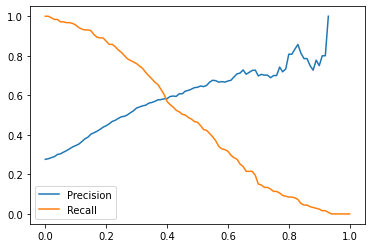

In [15]:
plt.plot(df_scores.threshold, df_scores['precision'], label='Precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='Recall')
plt.legend()

At which threshold precision and recall curves intersect?

* 0.2
* 0.4
* 0.6
* 0.8

At threshold 0.4, precision and recall curves intersect.

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [16]:
df_scores['f1'] = (2*df_scores['precision']*df_scores['recall'])/(df_scores['precision']+df_scores['recall'])
df_scores[['threshold', 'f1']].head()

,threshold,f1
0,0.00,0.432718
1,0.01,0.436557
2,0.02,0.442430
3,0.03,0.447734
4,0.04,0.460514


In [17]:
df_scores[df_scores['f1'] == df_scores['f1'].max()]['threshold']

30    0.3
Name: threshold, dtype: float64

At which threshold F1 is maximal?

- 0.1
- 0.3
- 0.5
- 0.7

At threshold 0.3, F1 is maximum.

## Question 5


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


In [18]:
def train(df_train, y_train, C):
    dicts = df_train[columns].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [19]:
def predict(df, dv, model):
    dicts = df[columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [20]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []
for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.default.values
    y_val = df_val.default.values

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

In [21]:
np.std(scores).round(3)

0.014

How large is standard devidation of the scores across different folds?

- 0.001
- 0.014
- 0.09
- 0.14

The standard deviation is 0.014 across different folds.

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

In [22]:
for C in tqdm([0.01, 0.1, 1, 10]):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    scores = []
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.default.values
        y_val = df_val.default.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s => Mean: %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/4 [00:00<?, ?it/s]

C=0.01 => Mean: 0.809 +- 0.013
C=0.1 => Mean: 0.812 +- 0.013
C=1 => Mean: 0.812 +- 0.014
C=10 => Mean: 0.814 +- 0.015


Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

C = 0.01 leads to the best mean score.